## Description:

This AI Browsing Agent is an intelligent assistant designed to explore, extract, and summarize information from the web efficiently.

It breaks down complex user queries into smaller, targeted search actions and optimizes search terms for more relevant results.

In [ ]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_google_genai langchain_community

In [ ]:
import os
from google.colab import userdata

%env GOOGLE_API_KEY = {userdata.get('GEMINI_API_KEY')}

%env LANGCHAIN_API_KEY = {userdata.get('LANGCHAIN_API_KEY')}
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [ ]:
import os, getpass

%env TAVILY_API_KEY = {userdata.get('TAVILY_API_KEY')}

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

## Defining ChatModel and State:

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")

In [ ]:
from typing import TypedDict, Annotated
import operator

class State(TypedDict):
    question: str  # User's query
    answer: str  # Final synthesized answer
    context: Annotated[list, operator.add]  # Web search results or context
    subtasks: list[str]  # Decomposed subtasks from the query

## Query Decomposition Node:

Purpose: Break down the user's query into smaller, actionable subtasks.

In [ ]:
def query_decomposition(state: State) -> State:
    """
    Break down the user's query into smaller, actionable subtasks.

    Args:
        state (State): The current state containing the user's query.

    Returns:
        State: The updated state with the decomposed subtasks.
    """
    try:
        # Ensure the input state has the required structure
        if "question" not in state or not isinstance(state["question"], str):
            raise ValueError("The state must contain a 'question' key with a non-empty string value.")

        # Construct the prompt for the LLM
        prompt = f"""
        Break down the following query into smaller, actionable tasks:
        {state['question']}
        Provide each task as a separate line.
        """

        # LLM-based node to process the query
        decomposition_result = llm.invoke(
            [
                SystemMessage(content="Break the given query into clear, actionable subtasks to address it effectively."),
                HumanMessage(content=prompt),
            ]
        )

        # Validate the response from the LLM
        if not decomposition_result or not hasattr(decomposition_result, "content"):
            raise RuntimeError("Failed to get a valid response from the Agent.")

        # Parse the response into a list of subtasks
        subtasks = decomposition_result.content.strip().split("\n")

        # Clean and filter the subtasks
        state["subtasks"] = [task.strip() for task in subtasks if task.strip()]

    except Exception as e:
        # Log the error and update the state with an error message
        error_message = f"Error during query decomposition: {str(e)}"
        state["error"] = error_message
        state["subtasks"] = []
        print(error_message)

    return state


## Search Web Node:

Purpose: Searches the web through tavily search tool.

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

def search_web(state):

    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

## Search Wikipedia Node

In [ ]:
def search_wikipedia(state):

    """ Retrieve docs from wikipedia """

    # Search

    search_docs = WikipediaLoader(query=state['question'],
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

## Generate Answer Node:

The purpose of the generate_answer node is to generate a concise and accurate response to the user's question by leveraging the provided context. It also tracks progress at key stages to keep users informed during the answer-generation process.

In [ ]:
def generate_answer(state):

    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question,
                                                       context=context)

    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])

    # Append it to state
    return {"answer": answer}


## Building the Graph

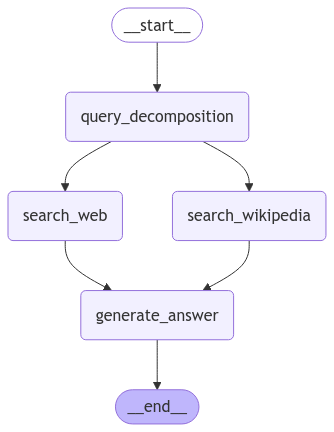

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
import pprint

builder: StateGraph = StateGraph(State)

builder.add_node("query_decomposition", query_decomposition)
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "query_decomposition")
builder.add_edge("query_decomposition", "search_web")
builder.add_edge("query_decomposition", "search_wikipedia")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)

graph: CompiledStateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Invoke

In [ ]:
result = graph.invoke({"question": "Best places to visit in South America for adventure tourism."})

pprint.pprint(result['answer'].content)

('Based on the provided text, several South American locations stand out as '
 'excellent destinations for adventure tourism:\n'
 '\n'
 '* **Torres del Paine National Park (Chile):**  Known for its diverse '
 'ecosystems and stunning scenery within the Andes Mountains.\n'
 '\n'
 '* **The Andes Mountains (various countries):**  Offering stunning views and '
 'a variety of outdoor activities.\n'
 '\n'
 '* **Los Roques (Venezuela):**  Described as having pristine beauty and '
 'diverse activities.\n'
 '\n'
 '* **Tierra del Fuego (Chile/Argentina):**  Unique location and stunning '
 'scenery.\n'
 '\n'
 '* **Amazon Rainforest/River/Basin (various countries):**  Offers many '
 'cultural and adventurous experiences.\n'
 '\n'
 '* **Iguazu Falls (Argentina/Brazil):**  A popular natural wonder.\n'
 '\n'
 '* **Pantanal Wetlands (Brazil):** Another popular natural wonder.\n'
 '\n'
 '* **Ecuadorian Andes:**  Features bike trips through stunning landscapes '
 '(Cotopaxi, Quilotoa, Chimborazo).\n'
 '

In [ ]:
result = graph.invoke({"question": "What are the adventure sports that help build endurance?"})

pprint.pprint(result['answer'].content)

('Based on the provided text, several adventure sports help build endurance:\n'
 '\n'
 '* **Adventure racing:** This involves multiple disciplines like trekking, '
 'mountain biking, and paddling, all requiring significant endurance.  The '
 'text emphasizes that training for this sport focuses on building endurance '
 'across all disciplines.\n'
 '* **Long-distance running:** This is explicitly mentioned as a form of '
 'endurance running, crucial for building stamina and cardiovascular fitness.  '
 "It's highlighted as a key component of training for adventure races.  "
 'Variations include track running, road running, and cross-country running.\n'
 '* **Ultramarathons:**  The example of Dean Karnazes, an ultramarathon '
 'runner, showcases the extreme endurance required in this sport, involving '
 'distances far beyond a standard marathon.\n'
 '\n'
 '\n'
 'While the text mentions other adventure sports like climbing and navigating '
 "rapids, it doesn't directly link them to enduran

In [ ]:
result

{'question': "What are the world's oldest archeological sites?",
 'answer': AIMessage(content="Based on the provided text, Lomekwi 3 in Kenya is considered by some scholars to be the oldest known archaeological site in the world.  Another strong contender is a site in Ethiopia, though the text doesn't name it specifically.  The texts also mention other very old sites, such as Jericho (around 11,000 years old), but these are not definitively the *oldest*.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-ed561938-5217-4d45-ad64-802f7387c210-0', usage_metadata={'input_tokens': 2639, 'output_tokens': 85, 'total_tokens': 2724, 'input_token_details': {'cache_read': 0}}),
 'context': ['<Document href="https://www.livescience.com/oldest-archaeological-site.html"/>\nIt turns out, there are two spots — one in Kenya and the other in Ethiopia — that are considered the top candidates for 